<a href="https://colab.research.google.com/github/chuchienhua/Personal-website/blob/main/Pokemon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
uploaded = files.upload()

Saving Pokemon.zip to Pokemon.zip


In [2]:
!unzip "Pokemon.zip"

Archive:  Pokemon.zip
   creating: Pokemon/
   creating: Pokemon/test/
  inflating: Pokemon/test/0.jpg      
  inflating: Pokemon/test/1.jpg      
  inflating: Pokemon/test/10.jpg     
  inflating: Pokemon/test/11.jpg     
  inflating: Pokemon/test/12.jpg     
  inflating: Pokemon/test/13.jpg     
  inflating: Pokemon/test/14.jpg     
  inflating: Pokemon/test/15.jpg     
  inflating: Pokemon/test/16.jpg     
  inflating: Pokemon/test/17.jpg     
  inflating: Pokemon/test/18.jpg     
  inflating: Pokemon/test/19.jpg     
  inflating: Pokemon/test/2.jpg      
  inflating: Pokemon/test/20.jpg     
  inflating: Pokemon/test/21.jpg     
  inflating: Pokemon/test/3.jpg      
  inflating: Pokemon/test/4.jpg      
  inflating: Pokemon/test/5.jpg      
  inflating: Pokemon/test/6.jpg      
  inflating: Pokemon/test/7.png      
  inflating: Pokemon/test/8.jpg      
  inflating: Pokemon/test/9.jpg      
   creating: Pokemon/train/
   creating: Pokemon/train/Arcanine/
  inflating: Pokemon/train/A

Found 967 images belonging to 22 classes.
data batch shape:  (5, 224, 224, 3)
labels:  Hitmonchan


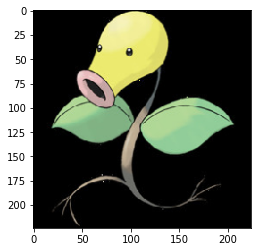

In [4]:
# 接下來利用現成的模型來遷移學習自己的資料集

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Activation
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 參數設置
img_width, img_height = 224,224 # 輸入圖片的長寬
input_depth = 3 # RGB
train_data_dir = './Pokemon/train' # 圖片資料夾路徑
epochs = 2 # 遷移學習訓練次數
batch_size = 5 # 資料匹次數

# 宣告一個Keras的Image Generator，用於讀取、處理圖片
train_datagen = ImageDataGenerator(rescale=1/255)


# 匹次讀取圖片，設置讀取方式
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    color_mode='rgb',# RGB
    target_size=(img_width,img_height),# 圖片大小
    batch_size=batch_size,# 資料匹次數
    class_mode='categorical')# 資料集模式，這邊我們是要影像分類，所以選categorical

# 顯示圖片
for data_batch, labels_batch in train_generator:
    print('data batch shape: ', data_batch.shape)
    plt.imshow(data_batch[0])
    print('labels: ', list(train_generator.class_indices)[np.argmax(labels_batch[2])])
    break

In [5]:
# 導入工具，包含預訓練模型(以InceptionV3為例)
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

# 宣告預訓練模型，並設置不包含輸出層(include_top)
base_model = InceptionV3(weights='imagenet', include_top=False)

# 自行建立輸出層
x = base_model.output
x = GlobalAveragePooling2D()(x)
# 增加兩層全連接層，輸出數量要注意
x = Dense(1024, activation='relu')(x)
predictions = Dense(22, activation='softmax')(x)

# 模型整合起來
model = Model(inputs=base_model.input, outputs=predictions)

# 設定不更新預訓練模型的權重
for layer in base_model.layers:
    layer.trainable = False

# 設置loss、優化器
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')

# 開始訓練
model.fit_generator(
    train_generator,#our training generator
    steps_per_epoch=np.floor(train_generator.n/batch_size),
    epochs=epochs)

87916544/87910968 [==============================] - 1s 0us/step


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/2
193/193 [==============================] - 114s 569ms/step - loss: 2.6484
Epoch 2/2
193/193 [==============================] - 110s 567ms/step - loss: 0.9192


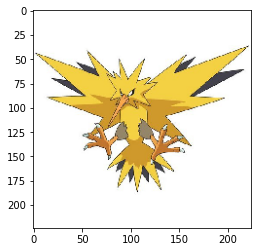

[[4.4677238e-04 1.6933889e-06 6.4830624e-07 3.8626720e-07 5.4615427e-08
  2.4437113e-06 8.5493372e-07 2.0196701e-05 6.0844276e-04 1.4992297e-08
  1.2987682e-07 4.4859387e-09 1.9823815e-06 3.6799363e-05 9.7461793e-07
  4.8755879e-07 4.7714857e-06 1.1976550e-07 4.3194908e-07 2.9801143e-07
  9.9635308e-06 9.9886250e-01]]
labels:  Zapdos


In [6]:
from tensorflow.keras.applications.inception_v3 import preprocess_input as preprocess_input_inception_v3
from tensorflow.keras.applications.inception_v3 import decode_predictions as decode_predictions_inception_v3

# 選擇要驗證的圖片
img_path = './Pokemon/test/1.jpg' 
img = image.load_img(img_path, target_size=(224, 224))
plt.imshow(img)
plt.show()
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input_inception_v3(x)

features = model.predict(x)
print(features)
print('labels: ', list(train_generator.class_indices)[np.argmax(features)])